<a href="https://colab.research.google.com/github/VenkatSR-14/Deeplearning-Code/blob/main/imdb_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMDB is an online database of information related to films, tv, series, etc. This dataset contains reviews that divided into positive and negative reviews. So, in this project we will do sentiment analysis where we asked to classify whether a review is tend to positive or negative.

Dataset Source: Kaggle


Review
Sentiment

In [1]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.metrics import classification_report, confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# read data
data = pd.read_csv('/content/IMDB Dataset.csv')
data.head()
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))
def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 825897.51it/s]


,review,sentiment,token_length,label
0,One of the other reviewers has mentioned that ...,positive,307,1
1,A wonderful little production. <br /><br />The...,positive,162,1
2,I thought this was a wonderful way to spend ti...,positive,166,1
3,Basically there's a family where a little boy ...,negative,138,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,1


In [3]:
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:00<00:00, 69589.48it/s]


In [4]:
data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

In [5]:
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

<Figure size 500x800 with 0 Axes>

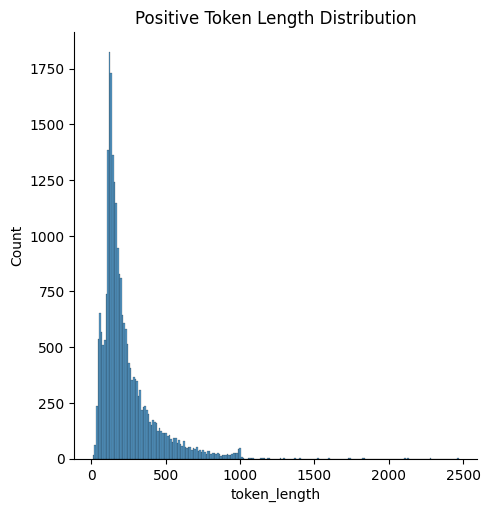

In [6]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Positive Token Length Distribution')
plt.show()

<Figure size 500x800 with 0 Axes>

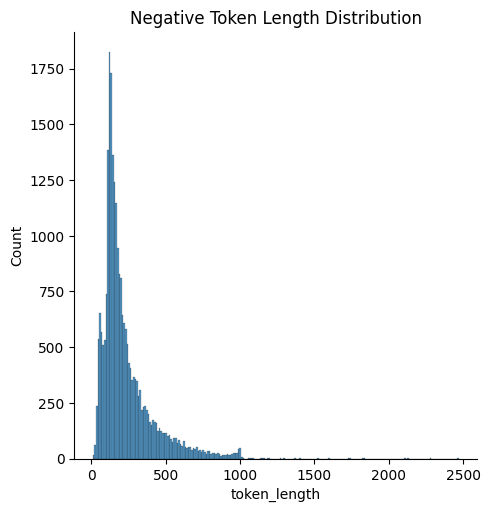

In [7]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Negative Token Length Distribution')
plt.show()

In [8]:
print('Positive')
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min()]['review'].item())
print()
print('Negative')
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min()]['review'].item())

Positive
Brilliant and moving performances by Tom Courtenay and Peter Finch.

Negative
Primary plot!Primary direction!Poor interpretation.


In [9]:
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    # return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [10]:
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data['clean'] = data['review'].progress_apply(clean_pipeline)

data.head()

In [14]:
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)

100%|██████████| 50000/50000 [01:49<00:00, 456.20it/s]


In [15]:
# keep only processed and label columns
data[['processed', 'label']].to_csv('./imdb_processed.csv', index=False, header=True)

In [16]:
data = pd.read_csv('./imdb_processed.csv')
data.head()

for row in data[:2].iterrows():
    print(row[1]['processed'])
    print(f'Label: {row[1]["label"]}')
    print('\n')

One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard sold nickel 

In [18]:
reviews = data.processed.values
words = ' '.join(reviews)
words = words.split()
words[:10]

['One',
 'reviewer',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'hooked',
 '.',
 'They',
 'right']

In [24]:
counter = Counter(words)
vocab = sorted(counter, key =  counter.get, reverse = True)
int2word = dict(enumerate(vocab,1))
int2word[0] ='<PAD>'
word2int = {word: index for index, word in int2word.items()}

In [25]:
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

100%|██████████| 50000/50000 [00:01<00:00, 33349.48it/s]


In [33]:
def pad_features(reviews, pad_id, seq_length=128):
    # features = np.zeros((len(reviews), seq_length), dtype=int)
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10]

array([[  191,  1083,   930,    81,  3724,   186,  3030,     1,   118,
          114],
       [   47,   328,    59,   244,     1,     7,  1267,  1608, 17875,
            4],
       [    3,    95,   328,    30,  1041,    13,   845,  1774,  2633,
            2],
       [ 2408,   136,    59,   241,  3230,    37,   650,  4298,   583,
          882],
       [70982, 10566,  1081,  1941,  7538,  2280,  1313,     6,    46,
            1],
       [ 2795,     4,    13,   368,     5,     2,    17, 42503,     2,
         2952],
       [    3,   197,    18,    10,    21, 12517,  1904, 55922,   121,
         5112],
       [   14,    31,   427,     2,  1342,  4021,   165,    34,  2960,
            1],
       [47893,   980,   359,     6,     3,   180,   776,    81,     6,
            1],
       [   64,    10,   125,  2269,  5606,  1980,    10,     5,     1,
           64]])

In [32]:
labels = data.label.to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0])

In [34]:
# train test split
train_size = .7     # we will use 80% of whole data as train set
val_size = .5       # and we will use 50% of test set as validation set

# make train set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [35]:
print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))

17510 17490
3753 3747
3737 3763


In [36]:
# define batch size
batch_size = 128

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [41]:
# check our batches
dataiter = iter(trainloader)
x, y = next(dataiter)
print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[    7,  1443,  2944,  ...,     0,     0,     0],
        [    1,     1,     1,  ...,     0,     0,     0],
        [ 4283,   789, 25465,  ...,   191,    36,  4447],
        ...,
        [    3,  2362,   268,  ...,     0,     0,     0],
        [11049,   239,     2,  ...,     0,     0,     0],
        [13411,     8,    60,  ...,     0,     0,     0]])

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 1])


In [42]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer cz we will have binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ =  self.lstm(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # sigmoid
        o = self.sigmoid(o)

        return o

In [43]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [44]:
vocab_size = len(word2int)
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.25

# model initialization
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

SentimentModel(
  (embedding): Embedding(121301, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [45]:
# training config
lr = 0.001
criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 8
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5

In [46]:
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    model.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(trainloader):
        # add epoch meta info
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

        # move to device
        feature, target = feature.to(device), target.to(device)

        # reset optimizer
        optim.zero_grad()

        # forward pass
        out = model(feature)

        # acc
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # clip grad
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # update optimizer
        optim.step()

        # free some memory
        del feature, target, predicted

    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    ####################
    # validation model #
    ####################

    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(valloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')

            # move to device
            feature, target = feature.to(device), target.to(device)

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # free some memory
            del feature, target, predicted

        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    # reset model mode
    model.train()

    # add epoch meta info
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

    # print epoch
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
        epochloop.update()

    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    # force early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        # update epochs history
        history['epochs'] = e+1
        break

Training:  12%|█▎        | 1/8 [01:09<08:07, 69.71s/it, Val Loss: 0.694 | Val Acc: 0.505]

Epoch 1/8 | Train Loss: 0.698 Train Acc: 0.507 | Val Loss: 0.694 Val Acc: 0.505


Training:  38%|███▊      | 3/8 [02:23<04:06, 49.22s/it, Val Loss: 0.693 | Val Acc: 0.508]

Epoch 2/8 | Train Loss: 0.697 Train Acc: 0.503 | Val Loss: 0.693 Val Acc: 0.508


Training:  62%|██████▎   | 5/8 [03:37<02:57, 59.04s/it, Training batch 1/274]

Epoch 3/8 | Train Loss: 0.693 Train Acc: 0.514 | Val Loss: 0.695 Val Acc: 0.501
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training:  75%|███████▌  | 6/8 [04:51<01:34, 47.38s/it, Val Loss: 0.496 | Val Acc: 0.752]

Epoch 4/8 | Train Loss: 0.609 Train Acc: 0.658 | Val Loss: 0.496 Val Acc: 0.752


Training:  88%|████████▊ | 7/8 [06:06<00:54, 54.86s/it, Val Loss: 0.407 | Val Acc: 0.834]

Epoch 5/8 | Train Loss: 0.394 Train Acc: 0.839 | Val Loss: 0.407 Val Acc: 0.834


Training: 9it [07:20, 49.50s/it, Val Loss: 0.374 | Val Acc: 0.848]                       

Epoch 6/8 | Train Loss: 0.295 Train Acc: 0.889 | Val Loss: 0.374 Val Acc: 0.848


Training: 10it [08:35, 56.76s/it, Val Loss: 0.358 | Val Acc: 0.860]

Epoch 7/8 | Train Loss: 0.230 Train Acc: 0.917 | Val Loss: 0.358 Val Acc: 0.860


Training: 100%|██████████| 8/8 [09:50<00:00, 73.76s/it, Val Loss: 0.364 | Val Acc: 0.864]

Epoch 8/8 | Train Loss: 0.180 Train Acc: 0.941 | Val Loss: 0.364 Val Acc: 0.864
[WARNING] Validation loss did not improved (0.358 --> 0.364)


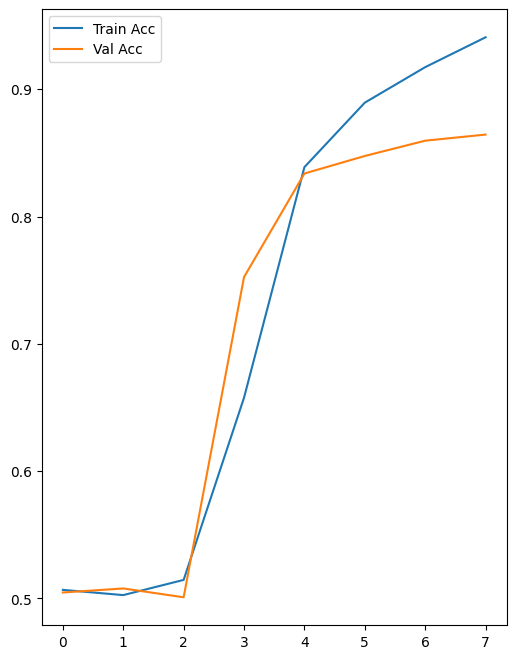

In [47]:
# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()

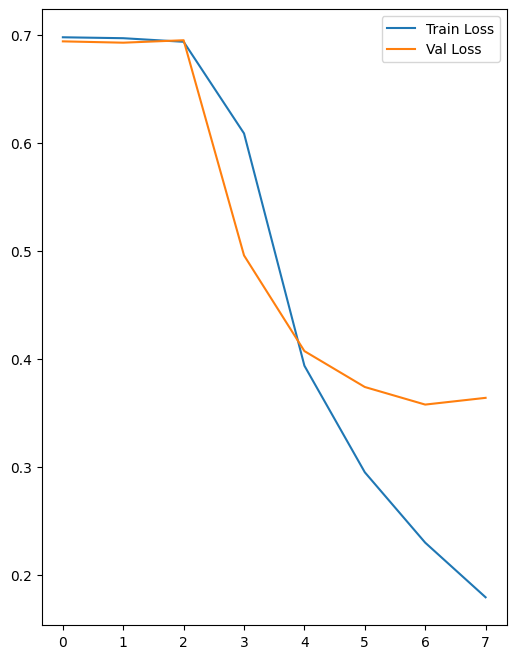

In [48]:
# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [49]:
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(testloader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)

        out = model(feature)

        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')

Inference: 100%|██████████| 59/59 [00:05<00:00, 11.66it/s]

Accuracy: 0.8692, Loss: 0.3545


In [50]:
print(classification_report(all_predicted, all_target))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      3876
           1       0.85      0.88      0.87      3624

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500



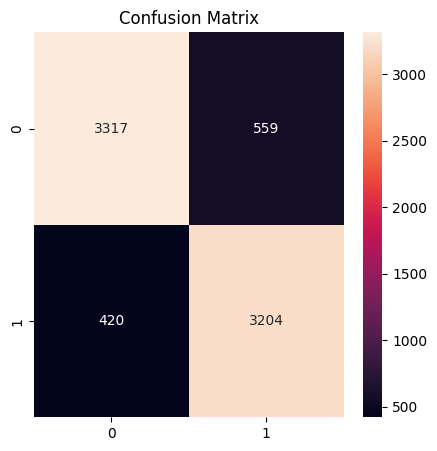

In [51]:
cm = confusion_matrix(all_predicted, all_target)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()

Conclusion
To sum up, here what we did along the project:

We taken IMDB movie review from kaggle consist of 50K positive and negative reviews and fortunately it has balance dataset.
We transform our label into 1 and 0 for positive and negative class respectively
We create our own cleaning and preprocessing script
Then we built vocabulary, encoding all reviews, add padding/trimming mechanism, making train test and validation set, create dataloader to make batches data
We built our model architecture, defining hyperparameters, writing training and validation loop, and we plot our loss and accuracies.
Then we do inference on test data, and surprisingly it still has a quite good performance with accuracy ~86%
Finally, we see our model evaluation using various metrics and plotting confusion matrix which showing that our model could classify most data correctly and not tends to specific class as we have balanced dataset.